# Instruments, data and methods

This section describes the two types of drifters deployed during OTC25, as well as the data and trajectory reconstruction methods used in our analysis.
We first present the design of the MELODI and SPOT drifters.
Next, we introduce the different satellite-derived and drifter datasets (including the preprocessing steps applied when relevant).
Finally, we detail the Lagrangian statistics used to characterize the drift dynamics, the trajectory reconstruction methods implemented, and the metrics employed to evaluate them.

## Drifters deployed during the campain

At the time of writing only eOdyn MELODI and IGE SPOT data are available. We therefore focus on these two types of drifters; however, it should be mentioned that 16 OpenMetBuoy, 4 CLS MARGE-T II, and 1 Sofar Spotter buoys were also deployed during the campaign.
Including these additional drifters would help strengthen our analysis, as described in @sec-disc.

::: {#fig-deployment-dream-team layout-ncol=2}

![](images/IMG_0855.jpeg){width=45%}

![](images/IMG_7459.jpeg){width=45%}

Drifters deployment dream team.
:::

Drifter deployments were conducted by a very enthusiastic team of students and professors, mostly visible in @fig-deployment-dream-team.
A huge thanks to all of you!!!

### MELODI

The MELODI [@MELODI] is a surface drifter developed by the company eOdyn.
Although we are only interested in the drifter's position, it also measures surface currents, surface temperature and wave parameters.
The position is determined using several satellite constellations, with a sampling frequency of 1 hour.
The drifter uses the Iridium satellite network to transmit its data.
It is powered by four Li-ion 3500 mAh, 3.7 V batteries and a 6 W solar panel, which allows it to operate for at least several months.
Thanks to its low-profile, see @fig-melodi-design, the MELODI drifter is expected to be only weakly affected by wind drift.

![Design of the MELODI drifter](images/melodi-design.png){#fig-melodi-design width=50%}

From Tromsø to Nice, 18 MELODI drifters were deployed in various locations: in the North Sea and its Lofoten eddy, in the North Atlantic (including during a storm event), before and after the Strait of Gibraltar (within the Alboran eddy), and in the western Mediterranean Sea.
This can be seen in @fig-drifter-deployments.

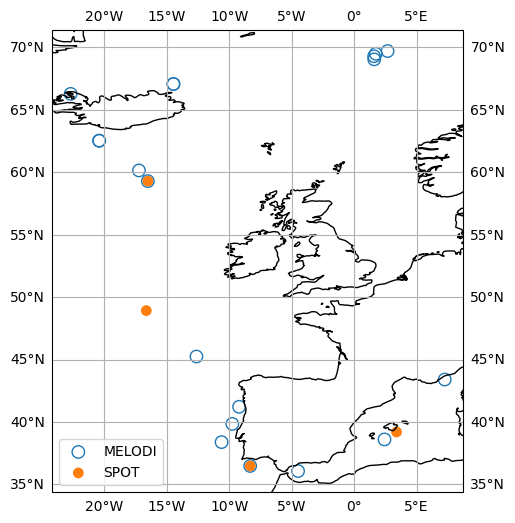

In [44]:
#| label: fig-drifter-deployments
#| fig-cap: "MELODI and SPOT drifter deployments during the OTC25 campaign."

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd


deployments = pd.read_csv("../data/drifters/deploy_time.csv", parse_dates=["deploy_time"], delimiter=" ")
deployments = deployments[deployments["type"].isin(["MELODI", "SPOT"])]
deployments = deployments.drop_duplicates(subset=["deploy_time", "lat", "lon"], keep="first")
deployments["lat"] = deployments["lat"].astype(float)
deployments["lon"] = deployments["lon"].astype(float)

style_map = {
    "MELODI": {"facecolors": "none", "edgecolors": "tab:blue", "marker": "o", "s": 80, "label": "MELODI"},
    "SPOT": {"facecolors": "tab:orange", "edgecolors": "none", "marker": "o", "s": 60, "label": "SPOT"},
}

fig, ax = plt.subplots(
    figsize=(8, 6),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

for t, style in style_map.items():
    subset = deployments[deployments["type"] == t]
    ax.scatter(
        subset["lon"], subset["lat"],
        transform=ccrs.PlateCarree(),
        **style
    )

ax.legend(loc="lower left")

ax.coastlines()
ax.gridlines(draw_labels=True)

plt.show()

### SPOT

The SPOT [@SPOT] is a home-made surface drifter designed and developed at Institut des Géosciences de l'Environnement (IGE).
Its design is very simple, see @fig-spot-design: a weighted waterproof jar containing a GPS tracer powered by external batteries.
The GPS tracer is a SPOT Trace, which uses the Globalstar satellite network to transmit its position every 30 minutes.
External batteries (4 LR20 alkaline 1.5V 13Ah) allow the drifter to operate for up to 6 months and counting at the time of writing.

![Design of the SPOT drifter](images/spot-design.png){#fig-spot-design width=75%}

During the first deployments we noticed that the SPOT drifters exhibited an orbital motion around their vertical axis and we suspected that it was the cause for the observed effective sampling frequency being larger than the nominal 30 minutes (see @fig-spot-sampling-frequency).
To mitigate this motion we designed a dynamic anchor attached to the bottom of the drifter.
Being at sea we had to reuse material available aboard the ship: old sails and steel wire ropes, as visible in @fig-spot-anchor.

![SPOT drifter with a dynamic anchor](images/IMG_0538.jpeg){#fig-spot-anchor width=75%}

The last 5 drifters deployed in the Mediterranean Sea were equipped with this anchor.
Using the drifter data presented in @sec-data-drif-traj it seems that the anchor was effective in improving the effective sampling frequency, as shown in @fig-spot-sampling-frequency.
Further analysis would be required to confirm this is due to the dynamic anchor and not because of an overall quieter sea state in the Mediterranean Sea.

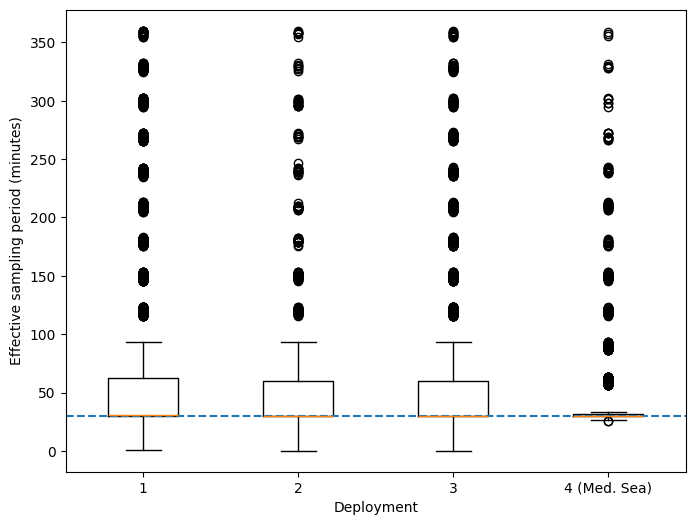

In [45]:
#| label: fig-spot-sampling-frequency
#| fig-cap: "SPOT drifters effective sampling period. The dashed blue line indicates the nominal sampling period of 30 minutes."

import os

import matplotlib.pyplot as plt
import pandas as pd


base_dir = "../data/drifters"
l1_dir = f"{base_dir}/l1"

df = pd.read_parquet(os.path.join(l1_dir, "spot_l1_df.parquet"))
deploy_times = df["deploy_time"].drop_duplicates().sort_values()

sampling_periods = []
for deploy_time in deploy_times:
    subset = df[df["deploy_time"] == deploy_time]
    sampling_periods.append(subset["dt"].dropna().to_numpy() / 60)

fig, ax = plt.subplots(figsize=(8, 6))

ax.boxplot(sampling_periods)
ax.axhline(30, color="tab:blue", linestyle="--")

ax.set_xticklabels(["1", "2", "3", "4 (Med. Sea)"])
ax.set_xlabel("Deployment")
ax.set_ylabel("Effective sampling period (minutes)")

plt.show()

## Satellite and drifter data

Our analysis requires both maps of geophysical quantities (surface currents, waves, winds) and lagrangian drifter trajectories. 

### Satellite-derived gridded products

Geophysical quantities of interest are derived from satellite observations, assimilated in physical models of varying complexity.

#### Sea Surface Height
VarDyn is a variational mapping method jointly reconstructing Sea Surface Height (SSH) and Sea Surface Temperature (SST) [@leguillouVarDynDynamicalJointReconstructions2025].
The version used in our analysis assimilates both SWOT KaRin and Nadir altimeters data and produces daily 0.05° $\times$ 0.05° maps.
This dataset provides both SSH and sea surface currents, derived from the SSH field using the cyclogeostrophic inversion method proposed by @bertrandRobustVariationalFramework2025 and implemented in the Python package `jaxparrow` [@bertrandJaxparrow2025].

#### Sea Surface Wind
Wind acts both directly on the drifter (the leeway) and indirectly through its effect on waves and currents.
We use the wind velocity at 10 meters above the surface from the 0.125° $\times$ 0.125° hourly ECMWF bias corrected product [@SeaSurfaceWind] developed by the Royal Netherlands Meteorological Institute.

#### Sea State
Waves also affect drifter trajectories through the Stokes drift.
We employ the Stokes drift obtained by assimilating significant wave height in the wave model MFWAM, available in the 0.083° $\times$ 0.083° hourly Global Ocean Waves Analysis and Forecast product [@SeaState] developed by Mercator Ocean International.

### Drifter trajectories {#sec-data-drif-traj}

Starting from the raw GPS positions transmitted by the drifters, we perform several preprocessing steps before using them in our analysis.

#### L0 version

The L0 version of the data consists of datasets containing the original timestamps and positions (latitude and longitude) for each drifter, complemented by its deployment date and time.
Each record also includes the time interval between successive measurements.

In [ ]:
#| echo: false

import glob
import os
import sys

import pandas as pd

sys.path.append(os.path.abspath("../src"))
from drifters_data import raw_to_l0


def do_raw_to_l0(dataset):
    raw_files = glob.glob(os.path.join(raw_dir, dataset, "*.json"))
    l0_df, l0_ds = raw_to_l0(raw_files, deployment_dates)

    l0_df.to_parquet(os.path.join(l0_dir, f"{dataset}_l0_df.parquet"), index=False)
    l0_ds.to_zarr(os.path.join(l0_dir, f"{dataset}_l0_ds.zarr"), mode="w")


base_dir = "../data/drifters"
raw_dir = f"{base_dir}/raw"
l0_dir = f"{base_dir}/l0"

deployment_dates = pd.read_csv(os.path.join(base_dir, "deploy_time.csv"), delimiter=" ")
deployment_dates["deploy_time"] = pd.to_datetime(deployment_dates["deploy_time"], format="%Y-%m-%dT%H:%M:%SZ", utc=True)

do_raw_to_l0("spot")
do_raw_to_l0("melodi")

#### L1 version

The L1 version of the data is produced by applying the following Quality Control (QC) steps to the L0 dataset:

1. Spurious GPS locations were removed following the procedure described by @elipotGlobalSurfaceDrifter2016,
2. Curated trajectories were divided into segments whenever the time gap between two consecutive timestamps exceeded 6 hours,
3. Segments shorter than 1 day are discarded.

In [1]:
#| echo: false

import os
import sys

import pandas as pd

sys.path.append(os.path.abspath("../src"))
from drifters_data import l0_to_l1


def do_l0_to_l1(dataset):
    l0_df = pd.read_parquet(os.path.join(l0_dir, f"{dataset}_l0_df.parquet"))
    l1_df, l1_ds = l0_to_l1(l0_df)

    l1_df.to_parquet(os.path.join(l1_dir, f"{dataset}_l1_df.parquet"), index=False)
    l1_ds.to_zarr(os.path.join(l1_dir, f"{dataset}_l1_ds.zarr"), mode="w")

    nobs_l0 = len(l0_df)
    ntraj_l0 = l0_df["drifter_id"].nunique()
    nobs_l1 = len(l1_df)
    ntraj_l1 = len(l1_ds["rows"])

    return nobs_l0, ntraj_l0, nobs_l1, ntraj_l1


base_dir = "../data/drifters"
l0_dir = f"{base_dir}/l0"
l1_dir = f"{base_dir}/l1"

nobs_spot_l0, ntraj_spot_l0, nobs_spot_l1, ntraj_spot_l1 = do_l0_to_l1("spot")
nobs_melodi_l0, ntraj_melodi_l0, nobs_melodi_l1, ntraj_melodi_l1 = do_l0_to_l1("melodi")

/Users/bertrava/miniconda3/envs/vb-phd/lib/python3.11/site-packages/zarr/api/asynchronous.py:228: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/Users/bertrava/miniconda3/envs/vb-phd/lib/python3.11/site-packages/zarr/api/asynchronous.py:228: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


As shown in @tbl-qc-numbers, these QC steps result in only a small reduction in the number of MELODI drifter observations.
In contrast, about 20% of the SPOT observations were discarded, primarily due to transmission issues that caused large gaps in the original trajectories and consequently led to many short segments being removed.

In [ ]:
#| label: tbl-qc-numbers
#| tbl-cap: Number of observations and segments in L0 and L1 versions for SPOT and MELODI datasets.

from IPython.display import display

import pandas as pd


column_names = pd.DataFrame(
    [
        ["# Observations", "L0"], 
        ["# Observations", "L1"], 
        ["# Segments", "L0"], 
        ["# Segments", "L1"]
    ],
    columns=["Dataset", ""]
)

rows = [
    [nobs_spot_l0, nobs_spot_l1, ntraj_spot_l0, ntraj_spot_l1],
    [nobs_melodi_l0, nobs_melodi_l1, ntraj_melodi_l0, ntraj_melodi_l1]
]

columns = pd.MultiIndex.from_frame(column_names)
index = ["SPOT", "MELODI"]

df = pd.DataFrame(rows, columns=columns, index=index)
display(df)

Dataset # Observations        # Segments     
                    L0     L1         L0   L1
SPOT             24503  19846         20  189
MELODI           47399  46837         19   39

#### L2 version

Trajectories are resampled at a regular time interval of 1 hour using a linear interpolation for the positions and the velocities are then computed using central differences.

In [2]:
#| echo: false

import os
import sys

import pandas as pd

sys.path.append(os.path.abspath("../src"))
from drifters_data import l1_to_l2


def do_l1_to_l2(dataset):
    l1_df = pd.read_parquet(os.path.join(l1_dir, f"{dataset}_l1_df.parquet"))
    l2_df, l2_ds = l1_to_l2(l1_df)

    l2_df.to_parquet(os.path.join(l2_dir, f"{dataset}_l2_df.parquet"), index=False)
    l2_ds.to_zarr(os.path.join(l2_dir, f"{dataset}_l2_ds.zarr"), mode="w")


base_dir = "../data/drifters"
l1_dir = f"{base_dir}/l1"
l2_dir = f"{base_dir}/l2"

do_l1_to_l2("spot")
do_l1_to_l2("melodi")

/Users/bertrava/miniconda3/envs/vb-phd/lib/python3.11/site-packages/zarr/api/asynchronous.py:228: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/Users/bertrava/miniconda3/envs/vb-phd/lib/python3.11/site-packages/zarr/api/asynchronous.py:228: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


An example of L0, L1 and L2 trajectories for a SPOT drifter is shown in @fig-drifter-processing.
It can be seen that the L0 trajectory contains some spurious points, which are removed in the L1 and L2 versions.
Holes in the L1 and L2 trajectories correspond to gaps larger than 6 hours in the original data.
Holes are not filled by interpolation in the L2 version as those trajectories are then considered as distinct segments.

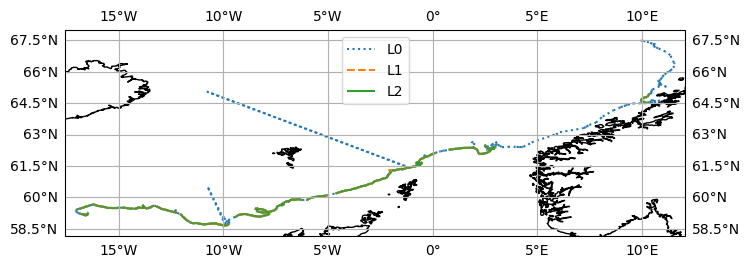

In [ ]:
#| label: fig-drifter-processing
#| fig-cap: "SPOT drifter 0-4498291 data (2025-05-12 – 2025-09-16) at different pre-processing levels."

import os 

import cartopy.crs as ccrs
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def add_lc(subset, style, min_lat, max_lat, min_lon, max_lon):
    lon = subset["lon"].to_numpy()
    lat = subset["lat"].to_numpy()

    segments = np.column_stack([lon[:-1], lat[:-1], lon[1:], lat[1:],]).reshape(-1, 2, 2)

    lc = LineCollection(segments, transform=ccrs.PlateCarree(), **style)
    ax.add_collection(lc)

    if np.min(lat) < min_lat:
        min_lat = np.min(lat)
    if np.max(lat) > max_lat:
        max_lat = np.max(lat)
    if np.min(lon) < min_lon:
        min_lon = np.min(lon)
    if np.max(lon) > max_lon:
        max_lon = np.max(lon)

    return min_lat, max_lat, min_lon, max_lon


base_dir = "../data/drifters"
l0_dir = f"{base_dir}/l0"
l1_dir = f"{base_dir}/l1"
l2_dir = f"{base_dir}/l2"

spot_l0_df = pd.read_parquet(os.path.join(l0_dir, "spot_l0_df.parquet"))
spot_l1_df = pd.read_parquet(os.path.join(l1_dir, "spot_l1_df.parquet"))
spot_l2_df = pd.read_parquet(os.path.join(l2_dir, "spot_l2_df.parquet"))

drifter_id = "0-4498291"

l0_df = spot_l0_df[spot_l0_df["drifter_id"] == drifter_id]
l1_df = spot_l1_df[spot_l1_df["drifter_id"] == drifter_id]
l2_df = spot_l2_df[spot_l2_df["drifter_id"] == drifter_id]

dfs = [l0_df, l1_df, l2_df]

styles = [
    {"linestyle": "dotted", "color": "tab:blue", "label": "L0"},
    {"linestyle": "dashed", "color": "tab:orange", "label": "L1"},
    {"linestyle": "solid", "color": "tab:green", "label": "L2"},
]

fig, ax = plt.subplots(
    figsize=(8, 6),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

min_lat = np.inf
max_lat = -np.inf
min_lon = np.inf
max_lon = -np.inf

for i in range(len(styles)):
    df = dfs[i]
    style = styles[i]

    if "traj_id" not in df.columns:
        min_lat, max_lat, min_lon, max_lon = add_lc(df, style, min_lat, max_lat, min_lon, max_lon)
    else:
        traj_ids = df["traj_id"].drop_duplicates().sort_values()
        for traj_id in traj_ids:
            subset = df[df["traj_id"] == traj_id]
            min_lat, max_lat, min_lon, max_lon = add_lc(subset, style, min_lat, max_lat, min_lon, max_lon)
            style.pop("label", None)

ax.set_xlim([min_lon - .5, max_lon + .5])
ax.set_ylim([min_lat - .5, max_lat + .5])

ax.legend(loc="upper center")

ax.coastlines()
ax.gridlines(draw_labels=True)

plt.show()

@fig-drifter-traj presents the L2 trajectories of both SPOT and MELODI drifters deployed between Tromsø and Nice during OTC25.

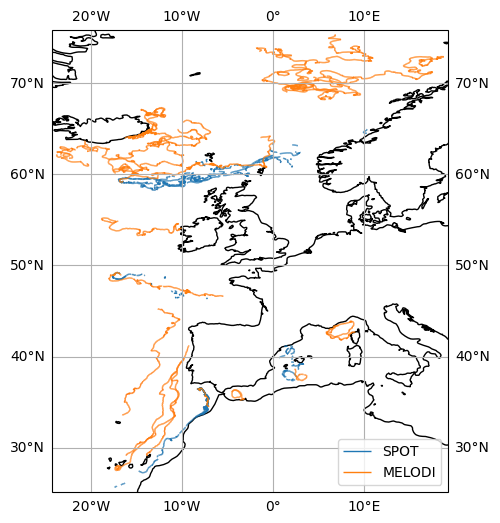

In [ ]:
#| label: fig-drifter-traj
#| fig-cap: "L2 drifters data from the OTC 25 (2025-04-25 – 2025-09-16)."

import os 

import cartopy.crs as ccrs
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def add_lc(subset, style, min_lat, max_lat, min_lon, max_lon):
    lon = subset["lon"].to_numpy()
    lat = subset["lat"].to_numpy()

    segments = np.column_stack([lon[:-1], lat[:-1], lon[1:], lat[1:],]).reshape(-1, 2, 2)

    lc = LineCollection(segments, transform=ccrs.PlateCarree(), **style)
    ax.add_collection(lc)

    if np.min(lat) < min_lat:
        min_lat = np.min(lat)
    if np.max(lat) > max_lat:
        max_lat = np.max(lat)
    if np.min(lon) < min_lon:
        min_lon = np.min(lon)
    if np.max(lon) > max_lon:
        max_lon = np.max(lon)

    return min_lat, max_lat, min_lon, max_lon


base_dir = "../data/drifters"
l2_dir = f"{base_dir}/l2"

spot_l2_df = pd.read_parquet(os.path.join(l2_dir, "spot_l2_df.parquet"))
melodi_l2_df = pd.read_parquet(os.path.join(l2_dir, "melodi_l2_df.parquet"))

dfs = [spot_l2_df, melodi_l2_df]

styles = [
    {"lw": 1, "color": "tab:blue", "label": "SPOT"},
    {"lw": 1, "color": "tab:orange", "label": "MELODI"},
]

fig, ax = plt.subplots(
    figsize=(8, 6),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

min_lat = np.inf
max_lat = -np.inf
min_lon = np.inf
max_lon = -np.inf

for i in range(len(styles)):
    df = dfs[i]
    style = styles[i]

    traj_ids = df["traj_id"].drop_duplicates().sort_values()
    for traj_id in traj_ids:
        subset = df[df["traj_id"] == traj_id]
        min_lat, max_lat, min_lon, max_lon = add_lc(subset, style, min_lat, max_lat, min_lon, max_lon)
        style.pop("label", None)

ax.set_xlim([min_lon - .5, max_lon + .5])
ax.set_ylim([min_lat - .5, max_lat + .5])

ax.legend(loc="lower right")

ax.coastlines()
ax.gridlines(draw_labels=True)

plt.show()

## Methods

This section describes the methods used to analyze the drifter trajectories and reconstruct their positions.
We first present the Lagrangian statistics used to characterize the drift dynamics.
Next, we introduce the trajectory reconstruction methods implemented in our analysis and we detail the metrics employed to evaluate them.

### Lagrangian statistics

#### Relative dispersion

The relative dispersion of a pair of drifters $(i, j)$ as a function of time is a measure of the spreading of a particle cloud around its center of mass.

The relative dispersion $\langle D^2_t \rangle$ will be computed using the $N=5$ custom-designed drifters only:
$$
    \langle D^2_t \rangle = \frac{1}{2N(N-1)} \sum_{i,j} d(\mathbf{X}^{(i)}_t, \mathbf{X}^{(j)}_t)^2
$$
where $\mathbf{X}^{(i)}_t$ denotes the position of the drifter $i$ at the discrete time $t$, and $d$ computes the distance on Earth between two points.

The rate of change of the relative dispersion is often characterized by computing the relative diffusivity $K$:

$$
K(t, \mathbf{X}(t), \mathbf{Y}(t)) = \frac{1}{4}\frac{d}{dt}D^2(t, \mathbf{X}(t), \mathbf{Y}(t))
$$

#### Finite Scale Lyapunov Exponent

If used...

### Trajectory modeling

We have selected two lagrangian models of different complexity to represent the drift of matter at the ocean surface.

#### Weighted linear combination

First, the drift is modeled as a simple linear combination of forces acting on the object:

$$
\frac{d\mathbf{X}(t)}{dt} = (\mathbf{u}_b + \mathbf{u}_e + \mathbf{u}_s + \beta_w \mathbf{u}_w)(t, \mathbf{X}(t))
$$

where $\mathbf{X}(t)$ is the position of the particle at time $t$, $\mathbf{u}_b$ is the current 2D field estimated from balanced SSH, $\mathbf{u}_e$ is the wind-induced Ekman current 2D field, $\mathbf{u}_s$ is the wave-induced Stokes drift 2D field, $\mathbf{u}_w$ is the wind velocity 2D field at 10 meters weighted by $\beta_w$. $( \cdot )(t, \mathbf{X}(t))$ denotes that the 2D field is interpolated in space and time at the particle position.

#### Maxey-Riley set

Another approach to the problem is to consider it from a fluid mechanics formulation, as a form of a Newton's second law:

$$
\mathbf{\ddot{X}} = \sum_i F_i
$$

where $\mathbf{\ddot{X}}$ is the particle acceleration and the involved forces are:

- The *flow force* exerted on the particle by the undisturbed fluid,
- The *added mass force* resulting from part of the fluid moving with the particle,
- The *lift force*, which arises when the particle rotates as it moves in a (horizontally) sheared flow,
- The *drag force* caused by the fluid viscosity,
- The *Coriolis force* accounting for the geophysical nature of the fluid.

This is an ideal deterministic model for spherical particles that can be adapted to different geometries, and we want to test its validity on real oceanic conditions.

#### Model evaluation

To evaluate the performance of the trajectory reconstruction methods, we integrate the models over N (to be fixed) days using the drifter positions as initial conditions.
We then compare the reconstructed trajectories to the drifter trajectories using the following metrics:

- **Relative dispersion**: the relative dispersion $D(t, \mathbf{X}_T, \mathbf{Y}_T)$ is computed between the reconstructed final position $\mathbf{X}_T$ and the drifter final position $\mathbf{Y}_T$.
- **Liu Index**: the Liu index [@liuEvaluationTrajectoryModeling2011] $s(t, \mathbf{X}(t), \mathbf{Y}(t))$ is computed between the reconstructed trajectory $\mathbf{X}(t)$ and the drifter trajectory $\mathbf{Y}(t)$.